In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
from __future__ import absolute_import,print_function,division
from keras import layers
import keras
import keras.backend as K
from pylab import rcParams
import tensorflow as tf 
import tensorflow.keras as keras
import matplotlib.pyplot as plt 
import numpy as np 
import os
import PIL
import imageio
import glob
import time 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
%matplotlib inline
from sklearn.utils import shuffle
import random
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import metrics

In [3]:
seq_len = 210
num_singal = 13
seq_step = 1
value = 0
width = num_singal
height = seq_len
channels = 1

In [4]:
def driver(seq_len, seq_step, num_singal,value):
    ##########################################################
    train=np.load('dataD_vse_13_normaly.npy',allow_pickle=True)
    ##########################################################
#     trains = pd.read_csv("Driving Data.csv")
#     print('load')
#     dataA,dataB,dataC,dataD,dataE,dataF,dataG,dataH,dataI,dataJ=DriverA(trains)
#     train = dataD.rolling(seq_length).std()
#     train = train.values
#     train = train[seq_length-1:,:]
#     train=train[2500:12000,:]
    m, n = train.shape  # m=562387, n=35
    # normalization
    for i in range(n - 1):
        # print('i=', i)
        A = max(train[:, i])
        # print('A=', A)
        if A != 0:
#             train[:,i] = (train[:,i]-train[:,i].mean())/(train[:,i].std())
            train[:,i] = (train[:,i]-train[:,i].min())/(train[:,i].max()-train[:,i].min())
#             train[:, i] /= max(train[:, i])
#             # scale from -1 to 1
#             train[:, i] = 2 * train[:, i] - 1
        else:
            train[:, i] = train[:, i]

    samples = train[:, :]
    labels = np.full(shape=(len(train)),fill_value=value)
    #labels = train[:, n - 1]  # the last colummn is label
    #############################
    ############################
    # -- apply PCA dimension reduction for multi-variate GAN-AD -- #
    from sklearn.decomposition import PCA
    X_n = samples
    ####################################
    ###################################
    # -- the best PC dimension is chosen pc=6 -- #
    n_components = num_singal
    pca = PCA(n_components)
    pca.fit(X_n)
    T_n = pca.transform(X_n)
    ex_var = pca.explained_variance_ratio_
    pc = pca.components_
    # projected values on the principal component
    T_n = np.matmul(X_n, pc.transpose(1, 0))
    samples = T_n
    # only for one-dimensional
#     samples = T_n.reshape([samples.shape[0], ])
    ###########################################
    ###########################################
    num_samples = (samples.shape[0] - seq_len) // seq_step
    aa = np.empty([num_samples, seq_len, num_singal])
    bb = np.empty([num_samples, seq_len, 1])
    #print(samples)
    #print(labels.shape)

    for j in range(num_samples):
        bb[j, :, :] = np.reshape(labels[(j * seq_step):(j * seq_step + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa[j, :, i] = samples[(j * seq_step):(j * seq_step + seq_len), i]

    samples = aa
#     samples = np.reshape(samples,[samples.shape[0],samples.shape[1],samples.shape[2],1])
    labels = bb

    return samples, labels

In [5]:
dataD_train,labelD = driver(seq_len, seq_step, num_singal,value)

In [6]:
dataD_train=dataD[np.random.choice(dataD.shape[0], dataD.shape[0]//2, replace=True), :,:]
dataD_train = np.reshape(dataD_train,[dataD_train.shape[0],dataD_train.shape[1],dataD_train.shape[2],1])

array([[[[ 0.26597373],
         [-0.66034503],
         [ 0.12964919],
         ...,
         [ 0.18701565],
         [-0.01660965],
         [ 0.        ]],

        [[ 0.26717952],
         [-0.66007957],
         [ 0.13169603],
         ...,
         [-0.39908193],
         [-0.01637679],
         [ 0.        ]],

        [[ 0.26681865],
         [-0.66030773],
         [ 0.12127676],
         ...,
         [-0.39889705],
         [-0.01374262],
         [ 0.        ]],

        ...,

        [[-0.6750223 ],
         [-0.98212973],
         [ 0.18015391],
         ...,
         [-0.27079815],
         [-0.01785247],
         [ 0.        ]],

        [[-0.67502241],
         [-0.98212944],
         [ 0.18015357],
         ...,
         [-0.27076376],
         [-0.01785249],
         [ 0.        ]],

        [[-0.67502241],
         [-0.98212944],
         [ 0.18015357],
         ...,
         [-0.27076376],
         [-0.01785249],
         [ 0.        ]]],


       [[[ 0.26717952],


In [7]:
def driver_test():    
    dataD = np.load('dataD_vse_13_normaly.npy',allow_pickle=True)
    dataD_1 = dataD[0:1500,:]
    dataD_2 = dataD[1500:3000,:]
    dataD_3 = dataD[3000:6000,:]
    dataD_4 = dataD[6000:7500,:]
    dataD_5 = dataD[10000:,:]
    dataD_normal=np.vstack((dataD_1,dataD_3))
    dataD_normal=np.vstack((dataD_normal,dataD_5))
    dataD_anormaly=np.vstack((dataD_2,dataD_4))
    for i in range (len(dataD_anormaly)):
        dataD_anormaly[i,0] = dataD_anormaly[i,0]*1.1
        dataD_anormaly[i,1] = dataD_anormaly[i,1]*2.5
        dataD_anormaly[i,2] = dataD_anormaly[i,2]*1.1
    dataD_contrib = np.vstack((dataD_normal,dataD_anormaly))
    label_0 = np.full(shape=(len(dataD_normal)),fill_value=0)
    label_1 = np.full(shape=(len(dataD_anormaly)),fill_value=1)
    m, n = dataD_contrib.shape
    for i in range(n):
        B = max(dataD_contrib[:, i])
        if B != 0:
    #         dataD_contrib[:,i] = (dataD_contrib[:,i]-dataD_contrib[:,i].mean())/(dataD_contrib[:,i].std())
            dataD_contrib[:,i] = (dataD_contrib[:,i]-dataD_contrib[:,i].min())/(dataD_contrib[:,i].max()-dataD_contrib[:,i].min())
    #         dataD_contrib[:, i] /= max(dataD_contrib[:, i])
    #             # scale from -1 to 1
    #         dataD_contrib[:, i] = 2 * dataD_contrib[:, i] - 1
        else:
            dataD_contrib[:, i] = dataD_contrib[:, i]
    dataD_normal = dataD_contrib[:dataD_normal.shape[0],:]
    dataD_anormaly = dataD_contrib[dataD_normal.shape[0]:,:]

    num_samples_0 = (dataD_normal.shape[0] - seq_len) // 1
    aa_0 = np.empty([num_samples_0, seq_len, num_singal])
    bb_0 = np.empty([num_samples_0, seq_len, 1])
    bbb_0 = np.empty([num_samples_0, seq_len, 1])
    for j in range(num_samples_0):
        bb_0[j, :, :] = np.reshape(label_0[(j * 1):(j * 1 + seq_len)], [-1, 1])
    #     bbb_0[j, :, :] = np.reshape(idx_0[(j * 1):(j * 1 + 120)], [-1, 1])
        for i in range(10):
            aa_0[j, :, i] = dataD_normal[(j * 1):(j * 1 + seq_len), i]

    num_samples_1 = (dataD_anormaly.shape[0] - seq_len) // 1
    aa_1 = np.empty([num_samples_1, seq_len, num_singal])
    bb_1 = np.empty([num_samples_1, seq_len, 1])
    bbb_1 = np.empty([num_samples_1, seq_len, 1])
    for j in range(num_samples_1):
        bb_1[j, :, :] = np.reshape(label_1[(j * 1):(j * 1 + seq_len)], [-1, 1])
    #     bbb_1[j, :, :] = np.reshape(idx_1[(j * 1):(j * 1 + 10)], [-1, 1])
        for i in range(num_singal):
            aa_1[j, :, i] = dataD_anormaly[(j * 1):(j * 1 + seq_len), i]
    aa_1_A = aa_1[:1440,:]
    aa_1_B = aa_1[1440:,:]
    bb_1_A = bb_1[:1440,:]
    bb_1_B = bb_1[1440:,:]
    dataD_test = np.insert(aa_0,1500,aa_1_A,axis=0)
    dataD_test = np.insert(dataD_test,5880,aa_1_B,axis=0)
    labelD_test = np.insert(bb_0,1500,bb_1_A,axis=0)
    labelD_test = np.insert(labelD_test,5880,bb_1_B,axis=0)
    labelD_test = np.reshape(labelD_test,[labelD_test.shape[0],labelD_test.shape[1]])
    labelD_test = np.sum(labelD_test,1)
    labelD_test[labelD_test > 1] = 1
        
    index = [i for i in range(len(dataD_test))]
    random.shuffle(index)
    dataD_test = dataD_test[index]
    labelD_test = labelD_test[index]
    np.save("./score/labelD_test_drunk_"+str(height)+".npy", labelD_test)
    
    dataD_test = np.reshape(dataD_test,[dataD_test.shape[0],dataD_test.shape[1],dataD_test.shape[2],1])
    return dataD_test,labelD_test

In [8]:
dataD_test,labelD_test = driver_test()

In [9]:
dataD_test.shape

(10323, 210, 13, 1)

In [10]:
#Generators Encoder
input_layer = layers.Input(name='input', shape=(height, width, channels))

# Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.Conv2D(256, (3,3), strides=(2,2), padding='same', name='conv_5', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_4')(x)
x = layers.LeakyReLU(name='leaky_5')(x)

x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

g_e.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 210, 13, 1)]      0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 210, 13, 32)       832       
_________________________________________________________________
leaky_1 (LeakyReLU)          (None, 210, 13, 32)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 105, 7, 64)        18496     
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 105, 7, 64)        256       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 105, 7, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 53, 4, 128)        73856 

In [11]:
#Generator
input_layer = layers.Input(name='input', shape=(height, width, channels))

x = g_e(input_layer)

y = layers.Dense(height*width, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((height, width,1), name='de_reshape')(y)

# y = layers.Conv2DTranspose(256, (3,3), strides=(1,1), padding='valid', name='deconv_0', kernel_regularizer = 'l2')(y)
# y = layers.LeakyReLU(name='de_leaky_0')(y)

y = layers.Conv2DTranspose(128, (3,3), strides=(1,1), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(1,1), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(1,1), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (3, 3), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 210, 13, 1)]      0         
_________________________________________________________________
model (Functional)           (None, 256)               538240    
_________________________________________________________________
dense (Dense)                (None, 2730)              701610    
_________________________________________________________________
de_reshape (Reshape)         (None, 210, 13, 1)        0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 210, 13, 128)      1280      
_________________________________________________________________
de_leaky_1 (LeakyReLU)       (None, 210, 13, 128)      0         
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 210, 13, 64)       7379

In [12]:
#Encoder
input_layer = layers.Input(name='input', shape=(height, width, channels))

z = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='encoder_conv_1', kernel_regularizer = 'l2')(input_layer)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='encoder_conv_2', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_1')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='encoder_conv_3', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_2')(z)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(256, (3,3), strides=(2,2), padding='same', name='encoder_conv_4', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_3')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(256, (3,3), strides=(2,2), padding='same', name='conv_41', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_4')(z)
z = layers.LeakyReLU()(z)

z = layers.GlobalAveragePooling2D(name='encoder_output')(z)

encoder = keras.models.Model(input_layer, z)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 210, 13, 1)]      0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 210, 13, 32)       832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 210, 13, 32)       0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 105, 7, 64)        18496     
_________________________________________________________________
encoder_norm_1 (BatchNormali (None, 105, 7, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 105, 7, 64)        0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 53, 4, 128)        7385

In [13]:
#feature extractor
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='f_conv_1', kernel_regularizer = 'l2')(input_layer)
f = layers.LeakyReLU(name='f_leaky_1')(f)

f = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='f_conv_2', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_1')(f)
f = layers.LeakyReLU(name='f_leaky_2')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_3', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_2')(f)
f = layers.LeakyReLU(name='f_leaky_3')(f)

f = layers.Conv2D(256, (3,3), strides=(2,2), padding='same', name='f_conv_4', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_3')(f)
f = layers.LeakyReLU(name='f_leaky_4')(f)

f = layers.Conv2D(256, (3,3), strides=(2,2), padding='same', name='f_conv_5', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_4')(f)
f = layers.LeakyReLU(name='feature_output')(f)

feature_extractor = keras.models.Model(input_layer, f)

feature_extractor.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 210, 13, 1)]      0         
_________________________________________________________________
f_conv_1 (Conv2D)            (None, 210, 13, 32)       832       
_________________________________________________________________
f_leaky_1 (LeakyReLU)        (None, 210, 13, 32)       0         
_________________________________________________________________
f_conv_2 (Conv2D)            (None, 105, 7, 64)        18496     
_________________________________________________________________
f_norm_1 (BatchNormalization (None, 105, 7, 64)        256       
_________________________________________________________________
f_leaky_2 (LeakyReLU)        (None, 105, 7, 64)        0         
_________________________________________________________________
f_conv_3 (Conv2D)            (None, 53, 4, 128)        7385

In [14]:
#gan trainer
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
# model for training
input_layer = layers.Input(name='input', shape=(height, width, channels))
gan = g(input_layer) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'cnt_loss': 20.0, 'adv_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)

In [15]:
gan_trainer.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 210, 13, 1)] 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 210, 13, 1)   1333675     input[0][0]                      
__________________________________________________________________________________________________
adv_loss (AdvLoss)              ()                   0           input[0][0]                      
                                                                 model_1[0][0]                    
__________________________________________________________________________________________________
cnt_loss (CntLoss)              ()                   0           input[0][0]                

In [16]:
#discriminator

input_layer = layers.Input(name='input', shape=(height, width, channels))

f = feature_extractor(input_layer)

d = layers.GlobalAveragePooling2D(name='glb_avg')(f)
d = layers.Dense(1, activation='sigmoid', name='d_out')(d)
    
d = keras.models.Model(input_layer, d)
d.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 210, 13, 1)]      0         
_________________________________________________________________
model_3 (Functional)         (None, 14, 1, 256)        981248    
_________________________________________________________________
glb_avg (GlobalAveragePoolin (None, 256)               0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 257       
Total params: 981,505
Trainable params: 980,097
Non-trainable params: 1,408
_________________________________________________________________


In [17]:
d.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
def Evaluation(data,label,epoch):
    #Evaluation
    encoded = g_e.predict(data)
    gan_x = g.predict(data)
    encoded_gan = g_e.predict(gan_x)
    score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
    score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1
    np.save("./score/driver_drunk"+str(epoch)+"_"+str(height)+".npy", score)
#     D_L = np.empty([score.shape[0], ])
#     for i in range(score.shape[0]):
#         if score[i]>np.percentile(score, 75):
#             # true/negative
#             D_L[i] = 1
#         else:
#             # false/positive
#             D_L[i] = 0
    # fpr, tpr, thresholds = metrics.roc_curve(labelAF, D_L, pos_label = 0)
    # Auc = metrics.auc(fpr, tpr)
#     precision, recall, f1, _ = precision_recall_fscore_support(labelD_test, D_L, average='binary')        
    rcParams['figure.figsize'] = 14, 5
    plt.scatter(range(len(score)),score, c=['skyblue' if x == 0 else 'pink' for x in label])
    plt.savefig("./plot/driver_drunk"+str(epoch)+"_"+str(height)+".png")
    plt.clf()
    plt.close()
    return #precision, recall, f1

In [19]:
#Training

niter = 50000
bz = 32
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]        

In [20]:
train_data_generator = get_data_generator(dataD_train, bz)

In [21]:
for i in range(niter):
    
    ### get batch x, y ###
    x, y = train_data_generator.__next__() 
    ### train disciminator ###
    d.trainable = True
        
    fake_x = g.predict(x)
        
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
        
    d_loss = d.train_on_batch(d_x, d_y)

    ### train generator ###
    
    d.trainable = False        
    g_loss = gan_trainer.train_on_batch(x, y)
    
    if i % 300 == 0:
        Evaluation(dataD_test,labelD_test,i)
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}\n')
#         print(f'precision: {precision}, recall: {recall}, f1: {f1}')

niter: 1, g_loss: [5.601454257965088, 4.170488491898455e-22, 0.0, 0.0], d_loss: 6.256426811218262

niter: 301, g_loss: [0.0898471549153328, 9.572007542146821e-08, 9.750744357006624e-05, 0.0007714746752753854], d_loss: 1.4616799354553223

niter: 601, g_loss: [0.019320862367749214, 9.73754026745155e-07, 0.00015121157048270106, 0.00028387096244841814], d_loss: 0.37496283650398254

niter: 901, g_loss: [0.5677976608276367, 0.07996038347482681, 0.014587851241230965, 0.10808705538511276], d_loss: 0.5387366414070129

niter: 1201, g_loss: [0.024473998695611954, 4.312503733672202e-06, 7.400968752335757e-05, 0.00040749908657744527], d_loss: 0.17704276740550995

niter: 1501, g_loss: [0.013535511679947376, 7.473980758732068e-07, 2.52585050475318e-05, 0.0004293660749681294], d_loss: 1.1617894172668457

niter: 1801, g_loss: [0.0035982169210910797, 5.3375799780042144e-08, 1.973814141820185e-05, 3.06607034872286e-05], d_loss: 0.8375533223152161

niter: 2101, g_loss: [1.9044772386550903, 1.6547410268685

niter: 18301, g_loss: [34.528968811035156, 0.01456661056727171, 0.9879539608955383, 0.06730516254901886], d_loss: 0.7841127514839172

niter: 18601, g_loss: [34.590248107910156, 0.0832817405462265, 0.9875906705856323, 0.06732773780822754], d_loss: 0.47549697756767273

niter: 18901, g_loss: [34.76506805419922, 0.2624122202396393, 0.9873858690261841, 0.06734424084424973], d_loss: 0.3194562494754791

niter: 19201, g_loss: [34.412906646728516, 0.07477857172489166, 0.9715421199798584, 0.21997341513633728], d_loss: 0.2261742204427719

niter: 19501, g_loss: [34.85010528564453, 0.361408531665802, 0.9867147207260132, 0.06742341816425323], d_loss: 0.16569823026657104

niter: 19801, g_loss: [34.6798095703125, 0.19618341326713562, 0.9864804148674011, 0.06744121760129929], d_loss: 0.12462341040372849

niter: 20101, g_loss: [34.93398666381836, 0.45628827810287476, 0.986207127571106, 0.06745213270187378], d_loss: 0.09565497189760208

niter: 20401, g_loss: [34.91082000732422, 0.43932491540908813, 0.985

niter: 36601, g_loss: [40.992366790771484, 0.0024174253921955824, 0.9962610602378845, 0.081072136759758], d_loss: 0.0036863377317786217

niter: 36901, g_loss: [100.95006561279297, 59.94002151489258, 0.9990114569664001, 0.0819307416677475], d_loss: 0.11881913244724274

niter: 37201, g_loss: [40.94556427001953, 0.00011360425560269505, 0.9972627758979797, 0.08190831542015076], d_loss: 0.0038142516277730465

niter: 37501, g_loss: [40.88492965698242, 0.012464210391044617, 0.9952144622802734, 0.08188027143478394], d_loss: 0.0008711900445632637

niter: 37801, g_loss: [40.923770904541016, 0.017184989526867867, 0.9986703991889954, 0.0818023681640625], d_loss: 0.0010629184544086456

niter: 38101, g_loss: [40842.14453125, 40801.20703125, 0.9976341724395752, 0.08290974795818329], d_loss: 0.25247249007225037

niter: 38401, g_loss: [42.17116165161133, 0.14255905151367188, 0.9985312223434448, 0.08210189640522003], d_loss: 0.6196585893630981

niter: 38701, g_loss: [41.953216552734375, 0.00200605904683

In [22]:
encoded = g_e.predict(dataD_test)
gan_x = g.predict(dataD_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [23]:
    D_L = np.empty([score.shape[0], ])
    for i in range(score.shape[0]):
    #     D_L[i] = np.mean(encoded_gan[i, :])
        if score[i]>0.459:
            # true/negative
            D_L[i] = 0
        else:
            # false/positive
            D_L[i] = 1
    # fpr, tpr, thresholds = metrics.roc_curve(labelAF, D_L, pos_label = 0)
    # Auc = metrics.auc(fpr, tpr)
    precision, recall, f1, _ = precision_recall_fscore_support(labelD_test, D_L, average='binary')        
    precision, recall, f1,

(0.0, 0.0, 0.0)

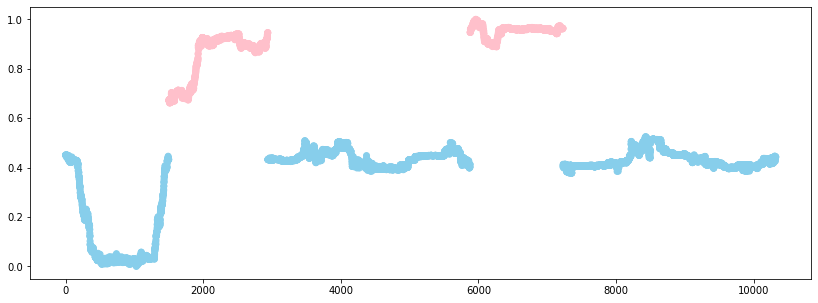

In [24]:
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(score)),score, c=['skyblue' if x == 0 else 'pink' for x in labelD_test])